In [1]:
'''
https://stackoverflow.com/questions/19873596/convex-hull-area-in-python

https://towardsdatascience.com/the-concave-hull-c649795c0f0f
'''

'\nhttps://stackoverflow.com/questions/19873596/convex-hull-area-in-python\n\nhttps://towardsdatascience.com/the-concave-hull-c649795c0f0f\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import json
import math
from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats
from scipy.stats import gaussian_kde

from scipy.spatial import ConvexHull, convex_hull_plot_2d

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

from scipy.signal import argrelextrema,argrelmax

from itertools import chain

In [3]:
from scipy.spatial import Delaunay
import numpy as np

# https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points

#  matlab boundary - https://stackoverflow.com/questions/31836709/what-algorithm-does-matlabs-boundary-function-use

# https://www.mathworks.com/help/matlab/ref/boundary.html

#  javascript implementation of hull - https://github.com/AndriiHeonia/hull

# alpha shape https://en.wikipedia.org/wiki/Alpha_shape
# https://doc.cgal.org/latest/Alpha_shapes_2/index.html

def alpha_shape(points, alpha, only_outer=False):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [4]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

210.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


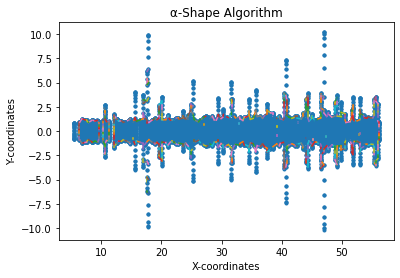

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 6, 6, 6, 25]
[13, 25, 39, 57, 76, 92, 103, 108, 110, 115, 118, 122, 125, 130, 134, 139, 143, 153, 159, 162, 166, 170, 181, 195, 198, 202, 207, 211, 215, 219, 223, 253, 255, 261, 265, 271, 273, 276, 297, 303, 305, 309, 312, 322, 329, 334, 337, 342, 347, 350, 353, 357, 361, 363, 376, 380, 410, 417, 442, 446, 472, 476, 494, 507, 529, 531, 543, 545, 632, 647, 652, 661, 670, 695, 707, 718, 40, 43, 49, 90, 19, 23, 76, 11]
[3.8300158322397775, 1.5342506015510111, 3.668278073309132, 1.5435, 3.8812, 1.5312, 2.1350424706777007, 1.5834, 2.124599999358042, 2.117985173917148, 1.4819, 1.4335, 2.1456893065187344, 1.7168588132685294, 1.695099992849142, 1.5428, 1.5801, 2.1319782816050825, 1.5837968816044925, 1.3831, 1.1392, 1.5612053226642646, 3.0760356274221983, 1.

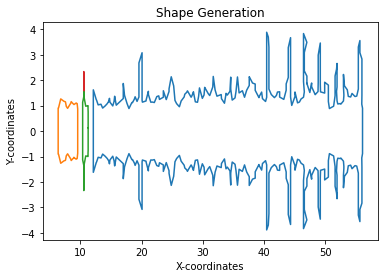

area = 140.0896482736005 , length = 197.82085973568655, bounds = (6.3729, -3.8812, 56.07, 3.8812), slope=0.15619422461270377
211.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


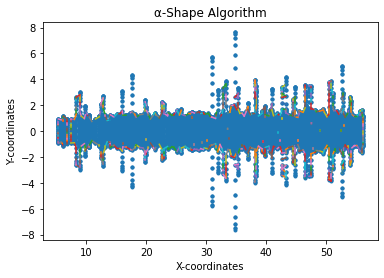

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3]
[1, 22, 24, 37, 52, 71, 96, 99, 106, 132, 141, 146, 153, 170, 175, 197, 199, 204, 209, 211, 214, 217, 219, 224, 231, 250, 258, 261, 263, 269, 295, 310, 320, 324, 333, 353, 358, 382, 388, 412, 420, 445, 496, 514, 530, 548, 560, 574, 588, 600, 618, 622, 626, 642, 662, 678, 682, 685, 688, 704, 714, 724, 726, 728, 732, 734, 739, 742, 746, 758, 772, 775, 786, 797, 803, 808, 1, 4, 40]
[2.552768969671536, 1.2409, 1.5022897573866982, 2.806485982276678, 0.92063, -0.9021, -0.9709, -1.2001, -0.73826, -0.8155600000000001, -1.0903, -1.2247, -1.0682, -0.92368, -1.0236, -1.1868, -1.2135, -1.2437, -1.1836, -1.3472, -1.3959, -1.3593, -1.3074, -0.97736, -1.037, -1.4242, -1.6574, -1.3719999999999999, -1.1557, -1.2607, -1.1681, -1.1713, -1.1865, -1.2223, -1.1812, -1.0607,

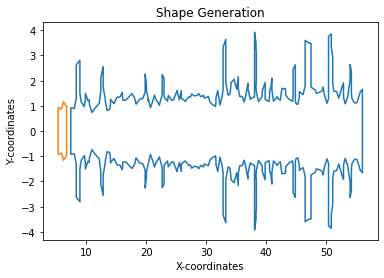

area = 148.90637741518782 , length = 192.8741545648185, bounds = (5.2723, -3.9224892772155537, 56.06399999999999, 3.9224892772155537), slope=0.15445394728727546
212.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


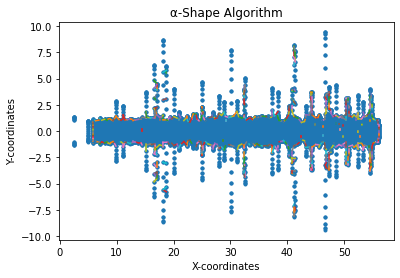

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 24, 35]
[18, 22, 24, 28, 33, 36, 43, 46, 50, 53, 55, 68, 74, 76, 78, 82, 91, 103, 122, 127, 131, 135, 141, 148, 152, 155, 161, 163, 167, 178, 200, 205, 236, 240, 265, 268, 270, 298, 301, 305, 309, 343, 396, 421, 433, 439, 441, 458, 472, 474, 487, 503, 523, 536, 551, 571, 574, 578, 581, 587, 589, 597, 602, 608, 610, 615, 628, 644, 657, 661, 664, 666, 671, 678, 687, 690, 692, 696, 700, 703, 708, 712, 715, 718, 721, 12, 10, 2]
[-0.98819, -1.0341, -1.033, -0.9938899999999999, -1.0298, -1.0709, -0.9844827659212564, -1.0438, -1.272691159461444, -1.2488, -1.2201, -1.3173, -1.0298, -1.1498, -1.2307, -0.9948100000000001, -0.8703, -0.9753299999999999, -1.0163, -1.176, -1.4933, -1.2932, -1.2383, -1.0462, -1.1021, -1.1937, -1.3813, -1.2911, -1

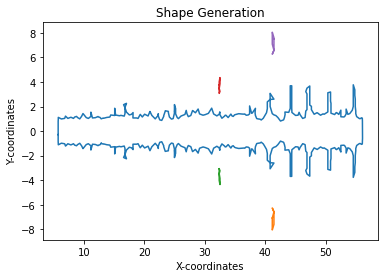

area = 138.79239515401702 , length = 188.4120262527731, bounds = (5.7744, -8.053659320668205, 56.044, 8.053659320668205), slope=0.3204186753293523
213.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)
<ipython-input-3-8f4a02c3ff71>:55: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - a) * (s - b) * (s - c))


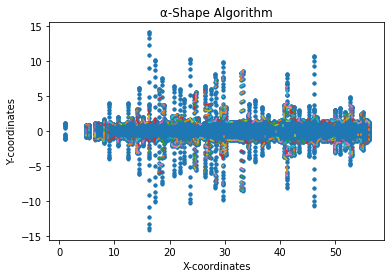

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 5, 5, 8, 9, 15, 15, 15, 24, 24, 24, 33, 34, 34, 34, 59]
[56, 65, 75, 81, 87, 93, 104, 117, 122, 134, 140, 143, 149, 153, 157, 159, 170, 172, 176, 182, 184, 189, 196, 206, 213, 218, 220, 223, 225, 231, 235, 237, 245, 258, 263, 266, 271, 274, 283, 290, 295, 303, 310, 312, 315, 320, 328, 335, 339, 342, 348, 350, 353, 394, 396, 402, 404, 411, 415, 425, 429, 431, 434, 444, 449, 453, 460, 469, 475, 477, 481, 495, 498, 506, 508, 516, 518, 520, 523, 527, 531, 537, 551, 554, 559, 565, 569, 578, 580, 585, 589, 594, 598, 612, 617, 620, 642, 645, 653, 667, 669, 6, 5, 10, 20, 45, 49, 6, 46, 2, 12, 24, 2, 4, 10, 8, 1, 7, 9, 1]
[2.687, 1.3879, 3.721367310512929, 2.3713507630306, 2.097582891

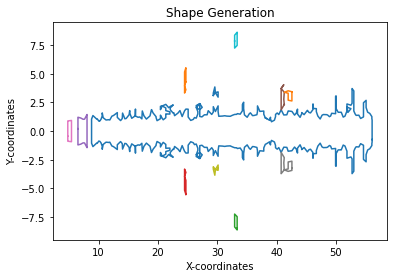

area = 148.23617316677888 , length = 232.0156303188553, bounds = (4.8028, -8.6416, 56.106, 8.6416), slope=0.3368834692572783
214.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


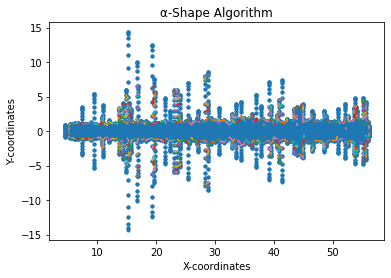

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 7, 7, 7, 9, 11, 16, 18]
[6, 13, 17, 19, 27, 44, 61, 78, 81, 86, 101, 127, 209, 222, 245, 255, 258, 270, 287, 307, 312, 323, 333, 349, 354, 357, 364, 376, 379, 382, 392, 394, 402, 405, 411, 430, 441, 443, 449, 452, 457, 462, 466, 473, 475, 497, 499, 504, 510, 522, 528, 534, 536, 543, 559, 563, 566, 569, 605, 609, 613, 618, 635, 638, 640, 646, 654, 666, 670, 675, 697, 699, 706, 709, 713, 718, 723, 725, 731, 740, 754, 767, 769, 778, 780, 790, 792, 795, 798, 805, 818, 821, 825, 834, 852, 6, 12, 1, 4, 9, 4, 2, 5, 12]
[-1.1613, -1.476, -1.74120000948904, -2.0540278067533366, -3.3536, -1.3265593434163239, -1.3671, -1.2692, -1.2352, -1.1676, -1.3854, -1.5567, 2.08809998117001, 3.653878792849458, 2.1335, 1.5

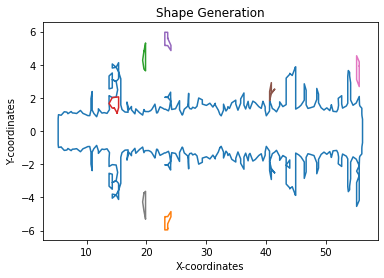

area = 161.37404148941212 , length = 231.57969935417114, bounds = (5.2408, -5.9628, 56.122, 5.9628), slope=0.2343812645928162
215.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


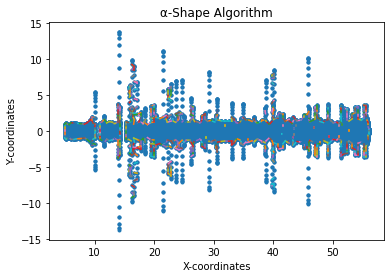

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 7, 11, 11, 11, 11, 11, 17, 27, 28, 43, 51]
[7, 15, 46, 52, 56, 83, 110, 211, 231, 264, 277, 280, 301, 321, 334, 348, 364, 374, 382, 384, 390, 394, 397, 408, 411, 415, 420, 422, 430, 445, 449, 458, 470, 476, 478, 496, 513, 516, 525, 531, 538, 540, 556, 594, 610, 617, 623, 630, 635, 638, 669, 672, 677, 681, 699, 701, 725, 743, 745, 748, 754, 756, 763, 771, 774, 779, 783, 787, 794, 816, 822, 834, 19, 25, 65, 76, 80, 12, 16, 10, 13, 54, 57, 131, 5, 7, 4, 14, 11]
[-2.2677168122806544, -1.2928, -1.1709, -1.1474, -1.0668422382038922, -1.3872, -1.5190000000000001, 3.5926, 3.3605, 3.4705667557986613, 1.2421, 1.8618500000000004, 3.5808, 2.7216580291013552, 1.9529, 1.6369, 2.4933, 2.0254500054046054, 1.6302000233445813, 1.5262, 1.7140374786770711, 1.5932, 1.90320000

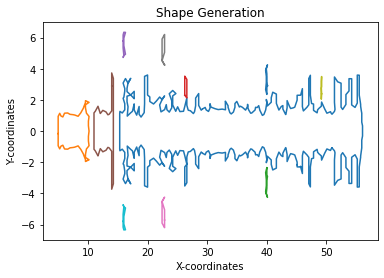

area = 160.9330684429835 , length = 258.1808655589442, bounds = (4.9254, -6.3408, 56.096000000000004, 6.3408), slope=0.24782980852286268
216.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


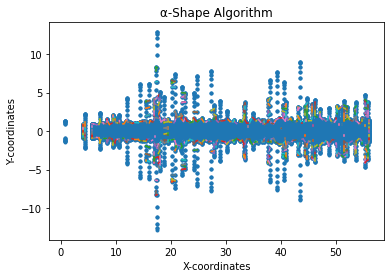

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 5, 11, 11, 32, 35, 35, 40]
[10, 15, 17, 47, 49, 57, 67, 87, 91, 99, 101, 107, 109, 131, 136, 147, 149, 160, 169, 177, 181, 185, 193, 197, 210, 212, 217, 222, 228, 254, 263, 266, 274, 286, 293, 295, 299, 307, 309, 331, 345, 351, 353, 358, 374, 381, 383, 386, 388, 392, 397, 417, 427, 434, 500, 502, 509, 530, 541, 543, 546, 548, 554, 557, 575, 578, 583, 590, 610, 622, 627, 634, 640, 644, 655, 667, 670, 674, 692, 707, 716, 720, 723, 733, 739, 747, 751, 756, 762, 766, 780, 789, 800, 803, 813, 815, 819, 822, 827, 832, 839, 849, 5, 7, 18, 1, 9, 1, 4, 8, 4]
[1.5275847518664514, 0.92766, 0.91995, -0.9029, -0.8279200000000001, -0.9528200000000001, -0.8517399999999999, -1.0143, -0.93984, -

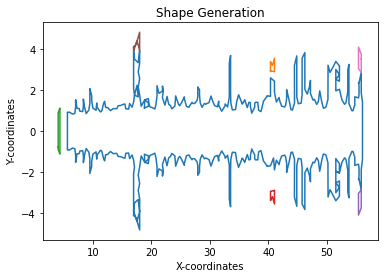

area = 154.36463183657392 , length = 236.11974603820315, bounds = (4.0514, -4.819777418686133, 56.08, 4.819777418686134), slope=0.18527415378027212
217.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


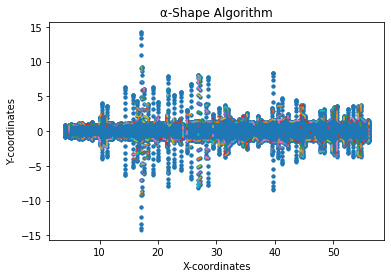

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 45, 51]
[2, 5, 9, 11, 17, 32, 37, 40, 45, 49, 52, 56, 63, 84, 88, 93, 109, 114, 121, 124, 131, 139, 142, 174, 177, 181, 188, 217, 228, 233, 261, 298, 313, 330, 338, 358, 376, 381, 385, 405, 420, 428, 434, 438, 443, 451, 460, 470, 477, 492, 501, 508, 6, 13, 24, 47, 53, 55, 99, 101, 103, 118, 134, 147, 155, 160, 162, 165, 178, 181, 187, 193, 195, 215, 219, 221, 225, 228, 266, 269, 273, 275, 283, 299, 305, 309, 313, 317, 330, 332, 336, 3, 4]
[1.358779625425964, 1.5465, 1.4124542881066768, 1.412, 1.5481000147995083, -1.2778, -1.3886, -1.3808974304592383, -1.3388461397177498, -1.2707, -1.2914, -1.2830000000000001, -1.8675000019711616, -1.54, -1.2198, -1.4291, -1.2874, -0.9233399999999999, -1.2613, -1.6123, -1.619260170489

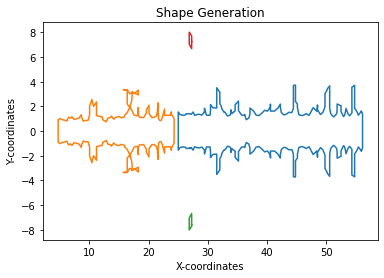

area = 154.11384454627247 , length = 205.37067698465864, bounds = (4.7309, -8.010426264934525, 56.095, 8.010426264934525), slope=0.31190758778736605


In [5]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width', 'slope']

fileName = []
area = []
length = []
height = []
width = []
slope = []

alphaValue = 0.35
ordBounLen = 10
maximaDistance = 0.4
        
# folders = ['contrails1', 'contrails2', 'contrails3']
folders = ['3-28-22']
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
#     onlyfiles = ['0.2.csv']
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        print(file)
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))

        points = np.vstack([x[inside], y[inside]]).T

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=alphaValue, only_outer=True)
        
        # Plotting the output
        plt.figure()
        plt.title('α-Shape Algorithm')
        plt.xlabel('X-coordinates')
        plt.ylabel('Y-coordinates')
        plt.plot(points[:, 0], points[:, 1], '.')
#         plt.ylim([-1, 1])
        for i, j in edges:
        #     print(i, j, points[[i, j], 0], points[[i, j], 1])

            plt.plot(points[[i, j], 0], points[[i, j], 1])

        # Save figure
#         plt.savefig('scatter_line.jpg', dpi=300, transparent=False, bbox_inches='tight')

        plt.show()
        
        



        orderedBoundaries = stitch_boundaries(edges)

        maxL = []
        index = []
        for i in range(len(orderedBoundaries)):
            if len(orderedBoundaries[i]) > ordBounLen:
                maxL.append(len(orderedBoundaries[i]))
                index.append(i)

        maximas = {}

        for i in index:
            X = []
            Y = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    X.append(points[j[0]][0])
                    X.append(points[j[1]][0])
                    Y.append(points[j[0]][1])
                    Y.append(points[j[1]][1])

                    count = count + 1
                else:
                    X.append(points[j[1]][0])
                    Y.append(points[j[1]][1])

            npx = np.array(X)
            npy = np.array(Y)

            lmIndex = argrelmax(npy)[0]

            lyp = npy[lmIndex]

            maximas[i] = [lmIndex, lyp]


        # print(maximas)
        # print(peakData)

#         commented out for getting non peak shape
        peakIds = []
        peakIndices = []
        peakData = []
        for key in maximas:
            peakIds = list(chain(peakIds, [key] * len(maximas[key][0])))
            peakIndices = list(chain(peakIndices, list(maximas[key][0])))
            peakData = list(chain(peakData, list(maximas[key][1])))

        print(peakIds)
        print(peakIndices)
        print(peakData)

        pdS = sorted(peakData, reverse=True)
        print(pdS)
        noise = "none"
#         toChange = pdS[0]
        toChange = 0
#         if pdS[0] - pdS[1] >= maximaDistance:
#             noise = pdS[0]
#             toChange = pdS[1]

#         # print(type(noise))
#         if noise != 'none':
#             ni = peakData.index(noise)
#             nid = peakIds[ni]
#             nind = peakIndices[ni]


        shapeData = []
        
        jsonData = []

        for i in index:
            bound = []
            jsonbound = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    if noise != 'none' and noise == abs(points[j[0]][1]):
                        if points[j[0]][1] < 0:
                            bound.append((points[j[0]][0], toChange * -1)) 
                            jsonbound.append({"X":points[j[0]][0], "Y": toChange * -1}) 
                        else:
                            bound.append((points[j[0]][0], toChange))
                            jsonbound.append({"X":points[j[0]][0], "Y": toChange}) 
                            
                        bound.append((points[j[1]][0], points[j[1]][1])) 
                        jsonbound.append({"X":points[j[1]][0], "Y": points[j[1]][1]}) 

                    elif noise != 'none' and noise == abs(points[j[1]][1]):                
                        bound.append((points[j[0]][0], points[j[0]][1]))
                        jsonbound.append({"X":points[j[0]][0], "Y": points[j[0]][1]}) 
                        if points[j[1]][1] < 0:
                            bound.append((points[j[1]][0], toChange * -1))
                            jsonbound.append({"X": points[j[1]][0], "Y":toChange * -1})
                        else:
                            bound.append((points[j[1]][0], toChange))
                            jsonbound.append({"X": points[j[1]][0], "Y": toChange})

                    else:
                        bound.append((points[j[0]][0], points[j[0]][1]))
                        bound.append((points[j[1]][0], points[j[1]][1]))
                        
                        jsonbound.append({'X': points[j[0]][0], 'Y': points[j[0]][1]})
                        jsonbound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})

                    count = count + 1
                else:
                    if noise != 'none' and noise == abs(points[j[1]][1]):
                        if points[j[1]][1] < 0:
                            bound.append((points[j[1]][0], toChange * -1))
                            jsonbound.append({"X": points[j[1]][0], "Y": toChange * -1})
                        else:
                            bound.append((points[j[1]][0], toChange))
                            jsonbound.append({"X": points[j[1]][0], "Y": toChange})

                    elif noise != 'none' and abs(points[j[1]][1]) > toChange:
                        pass
                    else:
                        bound.append((points[j[1]][0], points[j[1]][1]))
                        jsonbound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})

            poly = Polygon(bound)
        #             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
            shapeData.append(poly)
            
            jsonData.append(jsonbound)

        polygon = MultiPolygon(shapeData)

        minx,miny,maxx,maxy = polygon.bounds

        plt.figure()
        plt.title('Shape Generation')
        plt.xlabel('X-coordinates')
        plt.ylabel('Y-coordinates')
        for geom in polygon.geoms:
            x,y = geom.exterior.xy

            plt.plot(x,y)
            
        # Save figure
#         plt.savefig('shape.jpg', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        

#         fileName.append('{}_{}'.format(folder, file))
        fileName.append(file)
        area.append(round(polygon.area, 4))
        length.append(round(polygon.length, 4))
        h = abs(maxy - miny)
        height.append(round(h, 4))
        w = abs(maxx - minx)
        width.append(round(w, 4))
        s = (maxy - miny) / (maxx - minx)
        slope.append(round(s, 4))

        print("area = {} , length = {}, bounds = {}, slope={}".format(polygon.area , polygon.length, polygon.bounds, s))

        # print(fileName)
        # print(area)
        # print(length)
        # print(height)
        # print(width)
#         print(folder)
        similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width, slope]), columns = columns)
#         print(similarityAttributes)
        name = file.replace(".csv","")
#         with open('data/output/withNoise/{}/{}.json'.format(folder, name), 'w') as outfile:
#             json.dump(jsonData, outfile)
#         print("extracted {}".format(file))


In [6]:
similarityAttributes

,id,area,length,height,width,slope
0,210.csv,140.0896,197.8209,7.7624,49.6971,0.1562
1,211.csv,148.9064,192.8742,7.845,50.7917,0.1545
2,212.csv,138.7924,188.412,16.1073,50.2696,0.3204
3,213.csv,148.2362,232.0156,17.2832,51.3032,0.3369
4,214.csv,161.374,231.5797,11.9256,50.8812,0.2344
5,215.csv,160.9331,258.1809,12.6816,51.1706,0.2478
6,216.csv,154.3646,236.1197,9.6396,52.0286,0.1853
7,217.csv,154.1138,205.3707,16.0209,51.3641,0.3119


In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

attributes = similarityAttributes.iloc[:, 1:].values

scaler = StandardScaler()
scaler.fit(attributes)

scaled = scaler.transform(attributes)

print(scaled)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='kd_tree', metric='euclidean').fit(scaled)

distances, indices = nbrs.kneighbors(scaled)

print(distances)

name = list(similarityAttributes.id)

neighbors = {}
for indice in range(len(indices)):
    neighbors[name[indice]] = []   
#     print(indice)
    for i in range(0,len(indices[indice])):
#         pass
#         print(i)
        neighbors[name[indice]].append(name[indices[indice][i]])
    

[[-1.3515452  -0.85208201 -1.30828932 -1.85806098 -1.25986213]
 [-0.24425311 -1.0630869  -1.28502859 -0.21940887 -1.28441662]
 [-1.5144591  -1.25342511  1.04169207 -1.0010097   1.11181298]
 [-0.32842278  0.60651642  1.37283362  0.54632341  1.350136  ]
 [ 1.32153887  0.5879228  -0.13590349 -0.08542443 -0.13035547]
 [ 1.26616673  1.72261527  0.07699133  0.34781686  0.06319171]
 [ 0.44123614  0.78157962 -0.77965685  1.632271   -0.83954699]
 [ 0.40973845 -0.5300401   1.01736123  0.63749271  0.98904052]]
[[0.         1.98920676 3.47410556 3.87446854 4.30365539 4.46092287]
 [0.         1.98920676 2.78472944 2.80139877 3.45191692 3.66279907]
 [0.         2.63176314 2.72520769 3.47410556 3.66279907 3.89890456]
 [0.         1.44972588 2.67642113 2.72520769 2.7549895  3.35115368]
 [0.         1.24943019 2.16339652 2.27747605 2.7549895  2.80139877]
 [0.         1.24943019 2.1828111  2.67642113 2.76284805 3.74625095]
 [0.         2.16339652 2.1828111  2.78472944 3.04695398 3.35115368]
 [0.        

In [8]:
neighbors

{'210.csv': ['210.csv', '211.csv', '212.csv', '214.csv', '216.csv', '217.csv'],
 '211.csv': ['211.csv', '210.csv', '216.csv', '214.csv', '217.csv', '212.csv'],
 '212.csv': ['212.csv', '217.csv', '213.csv', '210.csv', '211.csv', '214.csv'],
 '213.csv': ['213.csv', '217.csv', '215.csv', '212.csv', '214.csv', '216.csv'],
 '214.csv': ['214.csv', '215.csv', '216.csv', '217.csv', '213.csv', '211.csv'],
 '215.csv': ['215.csv', '214.csv', '216.csv', '213.csv', '217.csv', '211.csv'],
 '216.csv': ['216.csv', '214.csv', '215.csv', '211.csv', '217.csv', '213.csv'],
 '217.csv': ['217.csv', '213.csv', '214.csv', '212.csv', '215.csv', '216.csv']}

In [9]:
attributes = similarityAttributes.iloc[:, 1:].values
attributes

array([['140.0896', '197.8209', '7.7624', '49.6971', '0.1562'],
       ['148.9064', '192.8742', '7.845', '50.7917', '0.1545'],
       ['138.7924', '188.412', '16.1073', '50.2696', '0.3204'],
       ['148.2362', '232.0156', '17.2832', '51.3032', '0.3369'],
       ['161.374', '231.5797', '11.9256', '50.8812', '0.2344'],
       ['160.9331', '258.1809', '12.6816', '51.1706', '0.2478'],
       ['154.3646', '236.1197', '9.6396', '52.0286', '0.1853'],
       ['154.1138', '205.3707', '16.0209', '51.3641', '0.3119']],
      dtype=object)

210.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


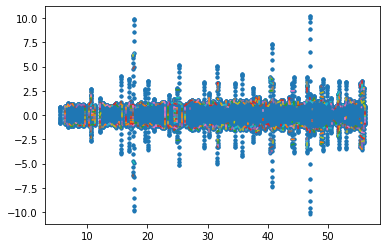

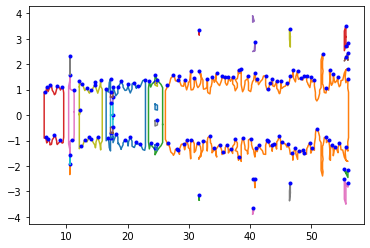

area = 113.43872887784059 , length = 207.66695256644743, bounds = (6.3729, -3.8812, 56.07, 3.8812), slope = 0.15619422461270377


In [10]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width']

fileName = []
area = []
length = []
height = []
width = []


        
folder = '3-28-22'
file = '210.csv'
df = pd.read_csv('data/input/{}/{}'.format(folder,file))
print(file)
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
# print(inside)
points = np.vstack([x[inside], y[inside]]).T
# print(points)

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.2, only_outer=True)


# Plotting the output
plt.figure()
plt.plot(points[:, 0], points[:, 1], '.')
# plt.ylim([-1, 1])
for i, j in edges:
#     print(i, j, points[[i, j], 0], points[[i, j], 1])

    plt.plot(points[[i, j], 0], points[[i, j], 1])


plt.show()

orderedBoundaries = stitch_boundaries(edges)

maxL = []
index = []
for i in range(len(orderedBoundaries)):
#     print(len(orderedBoundaries[i]))
    if len(orderedBoundaries[i]) > 5:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)

#         print(index, maxL)

X = []
Y = []
count = 0
shapeData = []
# print(orderedBoundaries)


for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            bound.append((points[j[0]][0], points[j[0]][1]))
            bound.append((points[j[1]][0], points[j[1]][1]))

            X.append(points[j[0]][0])
            X.append(points[j[1]][0])
            Y.append(points[j[0]][1])
            Y.append(points[j[1]][1])

            count = count + 1
        else:
            bound.append((points[j[1]][0], points[j[1]][1]))

            X.append(points[j[1]][0])
            Y.append(points[j[1]][1])

    poly = Polygon(bound)
#             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
    shapeData.append(poly)

polygon = MultiPolygon(shapeData)
minx,miny,maxx,maxy = polygon.bounds

slope = (maxy-miny)/(maxx-minx)

#         plt.plot([minx,maxx], [miny,maxy])
for geom in polygon.geoms:
    x,y = geom.exterior.xy


#     pp = sorted(y, reverse=True)
#     ppp = pp[:4]
#     print(type(y))           

    plt.plot(x,y)
    
    npx = np.array(x)
    npy = np.array(y)
    
    lmax = argrelmax(npy)[0]
    exmax = argrelextrema(npy, np.greater)[0]
    
    lyp = npy[lmax]
    eyp = npy[exmax]
    
#     maxima = pp[argrelmax(npy, np.greater)[0]]
    lxp = npx[lmax]
    exp = npx[exmax]    
    
    plt.plot(lxp, lyp, '.', color='blue')
#     plt.plot(exp, eyp, '.', color='red')
    
#     print("maximas ",sorted(lyp, reverse=True))
#     print("extremas", sorted(eyp, reverse=True))
    
    
plt.show()

#         ['id', 'area', 'length', 'height', 'width']

fileName.append(file)
area.append(round(polygon.area, 4))
length.append(round(polygon.length, 4))
h = abs(maxy - miny)
height.append(round(h, 4))
w = abs(maxx - minx)
width.append(round(w, 4))

print("area = {} , length = {}, bounds = {}, slope = {}".format(polygon.area , polygon.length, polygon.bounds, slope))
        
# print(fileName)
# print(area)
# print(length)
# print(height)
# print(width)
# similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width]), columns = columns)

211.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


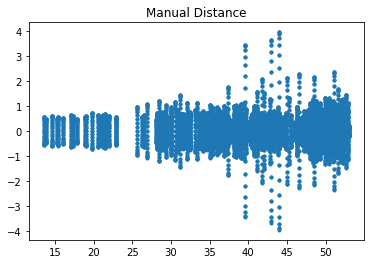

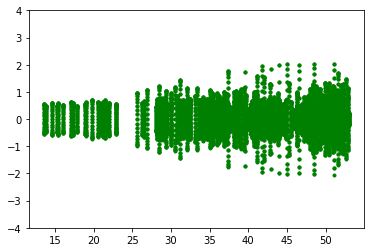

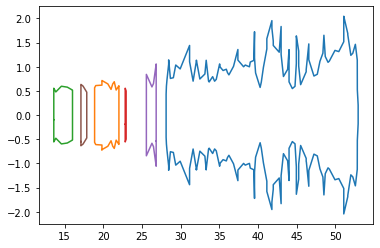

area = 62.44042575518492 , length = 104.39343629905926, bounds = (13.609000000000002, -2.044772586027938, 52.94600000000001, 2.0447725860279378)


In [11]:
folder = 'newData'
file = '211.csv'
df = pd.read_csv('data/input/{}/{}'.format(folder,file))
print(file)
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))

points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.4, only_outer=True)
# print(edges)

plt.figure()
plt.title("Manual Distance")
plt.plot(x, y, '.')
plt.show()

orderedBoundaries = stitch_boundaries(edges)

maxL = []
index = []
for i in range(len(orderedBoundaries)):
    if len(orderedBoundaries[i]) > 10:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)
        
maximas = {}

for i in index:
    X = []
    Y = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            X.append(points[j[0]][0])
            X.append(points[j[1]][0])
            Y.append(points[j[0]][1])
            Y.append(points[j[1]][1])

            count = count + 1
        else:
            X.append(points[j[1]][0])
            Y.append(points[j[1]][1])
            
    npx = np.array(X)
    npy = np.array(Y)
    
    lmIndex = argrelmax(npy)[0]
    
    lyp = npy[lmIndex]
    
    maximas[i] = [lmIndex, lyp]
    
    
# print(maximas)
# print(peakData)

peakIds = []
peakIndices = []
peakData = []
for key in maximas:
    peakIds = list(chain(peakIds, [key] * len(maximas[key][0])))
    peakIndices = list(chain(peakIndices, list(maximas[key][0])))
    peakData = list(chain(peakData, list(maximas[key][1])))

# print(peakIds)
# print(peakIndices)
# print(peakData)

pdS = sorted(peakData, reverse=True)
# print(pdS)
noise = "none"
toChange = pdS[0]
if pdS[0] - pdS[1] >= 0.4:
    noise = pdS[0]
    toChange = pdS[1]

# print(type(noise))
if noise != 'none':
    ni = peakData.index(noise)
    nid = peakIds[ni]
    nind = peakIndices[ni]
    
    
shapeData = []

for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            if noise != 'none' and noise == abs(points[j[0]][1]):
                if points[j[0]][1] < 0:
                    bound.append((points[j[0]][0], toChange * -1)) 
                else:
                    bound.append((points[j[0]][0], toChange))
                bound.append((points[j[1]][0], points[j[1]][1]))    
                
            elif noise != 'none' and noise == abs(points[j[1]][1]):                
                bound.append((points[j[0]][0], points[j[0]][1]))
                if points[j[1]][1] < 0:
                    bound.append((points[j[1]][0], toChange * -1))
                else:
                    bound.append((points[j[1]][0], toChange))
                
            else:
                bound.append((points[j[0]][0], points[j[0]][1]))
                bound.append((points[j[1]][0], points[j[1]][1]))

            count = count + 1
        else:
            if noise != 'none' and noise == abs(points[j[1]][1]):
                if points[j[1]][1] < 0:
                    bound.append((points[j[1]][0], toChange * -1))
                else:
                    bound.append((points[j[1]][0], toChange))
                    
            elif noise != 'none' and abs(points[j[1]][1]) > toChange:
                pass
            else:
                bound.append((points[j[1]][0], points[j[1]][1]))
        
        
    poly = Polygon(bound)
#             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
    shapeData.append(poly)

    
plt.figure()
xxx = []
yyy = []
for i in range(len(y)):
    if abs(y[i]) <= toChange:
        xxx.append(x[i])
        yyy.append(y[i])
plt.plot(xxx, yyy, 'g.')
plt.ylim(-4,4)
plt.show()
    
polygon = MultiPolygon(shapeData)

minx,miny,maxx,maxy = polygon.bounds

plt.figure()
for geom in polygon.geoms:
    x,y = geom.exterior.xy
    
    plt.plot(x,y)
plt.show()
    
fileName.append(file)
area.append(round(polygon.area, 4))
length.append(round(polygon.length, 4))
h = abs(maxy - miny)
height.append(round(h, 4))
w = abs(maxx - minx)
width.append(round(w, 4))

print("area = {} , length = {}, bounds = {}".format(polygon.area , polygon.length, polygon.bounds))
        
# print(fileName)
# print(area)
# print(length)
# print(height)
# print(width)
# similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width]), columns = columns)

In [13]:
BX = []
BY = []
for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            if noise != 'none' and noise == abs(points[j[0]][1]):
                if points[j[0]][1] < 0:
                    BX.append(points[j[0]][0])
                    BY.append(toChange * -1) 
                else:
                    BX.append(points[j[0]][0])
                    BY.append(toChange)
                BX.append(points[j[1]][0])
                BY.append(points[j[1]][1])    
                
            elif noise != 'none' and noise == abs(points[j[1]][1]):                
                BX.append(points[j[0]][0])
                BY.append(points[j[0]][1])
                if points[j[1]][1] < 0:
                    BX.append(points[j[1]][0])
                    BY.append(toChange * -1)
                else:
                    BX.append(points[j[1]][0])
                    BY.append(toChange)
                
            else:
                BX.append(points[j[0]][0])
                BY.append(points[j[0]][1])
                BX.append(points[j[1]][0])
                BY.append(points[j[1]][1])

            count = count + 1
        else:
            if noise != 'none' and noise == abs(points[j[1]][1]):
                if points[j[1]][1] < 0:
                    BX.append(points[j[1]][0])
                    BY.append(toChange * -1)
                else:
                    BX.append(points[j[1]][0])
                    BY.append(toChange)
                    
            elif noise != 'none' and abs(points[j[1]][1]) > toChange:
                pass
            else:
                BX.append(points[j[1]][0])
                BY.append(points[j[1]][1])

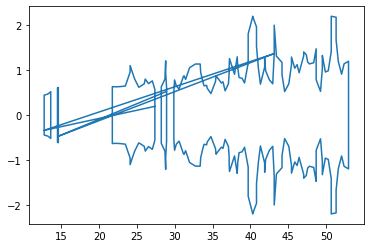

In [14]:
plt.figure()
plt.plot(BX, BY)
plt.show()

In [ ]:
{'contrails1_0.1.csv': ['contrails1_0.1.csv',
  'contrails1_0.19.csv',
  'contrails2_0.1.csv',
  'contrails3_0.1.csv',
  'contrails2_0.18.csv',
  'contrails2_0.14.csv'],
 'contrails1_0.11.csv': ['contrails1_0.11.csv',
  'contrails2_0.14.csv',
  'contrails1_0.18.csv',
  'contrails3_0.17.csv',
  'contrails2_0.18.csv',
  'contrails2_0.15.csv'],
 'contrails1_0.12.csv': ['contrails1_0.12.csv',
  'contrails3_0.19.csv',
  'contrails2_0.17.csv',
  'contrails3_0.2.csv',
  'contrails2_0.12.csv',
  'contrails2_0.16.csv'],
 'contrails1_0.13.csv': ['contrails1_0.13.csv',
  'contrails1_0.15.csv',
  'contrails3_0.18.csv',
  'contrails3_0.13.csv',
  'contrails2_0.16.csv',
  'contrails1_0.17.csv'],
 'contrails1_0.14.csv': ['contrails1_0.14.csv',
  'contrails1_0.16.csv',
  'contrails2_0.11.csv',
  'contrails3_0.16.csv',
  'contrails3_0.2.csv',
  'contrails2_0.13.csv'],
 'contrails1_0.15.csv': ['contrails1_0.15.csv',
  'contrails1_0.17.csv',
  'contrails3_0.13.csv',
  'contrails2_0.16.csv',
  'contrails3_0.2.csv',
  'contrails1_0.13.csv'],
 'contrails1_0.16.csv': ['contrails1_0.16.csv',
  'contrails3_0.16.csv',
  'contrails3_0.11.csv',
  'contrails1_0.14.csv',
  'contrails3_0.12.csv',
  'contrails3_0.14.csv'],
 'contrails1_0.17.csv': ['contrails1_0.17.csv',
  'contrails2_0.16.csv',
  'contrails1_0.15.csv',
  'contrails3_0.2.csv',
  'contrails3_0.12.csv',
  'contrails3_0.13.csv'],
 'contrails1_0.18.csv': ['contrails1_0.18.csv',
  'contrails3_0.17.csv',
  'contrails2_0.15.csv',
  'contrails2_0.17.csv',
  'contrails1_0.12.csv',
  'contrails3_0.11.csv'],
 'contrails1_0.19.csv': ['contrails1_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.1.csv',
  'contrails2_0.14.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv'],
 'contrails1_0.2.csv': ['contrails1_0.2.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv',
  'contrails2_0.2.csv',
  'contrails3_0.14.csv',
  'contrails1_0.19.csv'],
 'contrails2_0.1.csv': ['contrails2_0.1.csv',
  'contrails3_0.1.csv',
  'contrails1_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.19.csv',
  'contrails2_0.2.csv'],
 'contrails2_0.11.csv': ['contrails2_0.11.csv',
  'contrails2_0.13.csv',
  'contrails1_0.14.csv',
  'contrails3_0.15.csv',
  'contrails3_0.14.csv',
  'contrails1_0.16.csv'],
 'contrails2_0.12.csv': ['contrails2_0.12.csv',
  'contrails1_0.12.csv',
  'contrails2_0.16.csv',
  'contrails3_0.2.csv',
  'contrails2_0.17.csv',
  'contrails1_0.14.csv'],
 'contrails2_0.13.csv': ['contrails2_0.13.csv',
  'contrails2_0.11.csv',
  'contrails2_0.14.csv',
  'contrails3_0.14.csv',
  'contrails3_0.15.csv',
  'contrails1_0.14.csv'],
 'contrails2_0.14.csv': ['contrails2_0.14.csv',
  'contrails2_0.13.csv',
  'contrails2_0.18.csv',
  'contrails3_0.14.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv'],
 'contrails2_0.15.csv': ['contrails2_0.15.csv',
  'contrails2_0.17.csv',
  'contrails1_0.12.csv',
  'contrails3_0.19.csv',
  'contrails1_0.18.csv',
  'contrails3_0.17.csv'],
 'contrails2_0.16.csv': ['contrails2_0.16.csv',
  'contrails1_0.17.csv',
  'contrails3_0.2.csv',
  'contrails1_0.15.csv',
  'contrails2_0.12.csv',
  'contrails3_0.13.csv'],
 'contrails2_0.17.csv': ['contrails2_0.17.csv',
  'contrails2_0.15.csv',
  'contrails1_0.12.csv',
  'contrails3_0.2.csv',
  'contrails3_0.19.csv',
  'contrails3_0.12.csv'],
 'contrails2_0.18.csv': ['contrails2_0.18.csv',
  'contrails2_0.14.csv',
  'contrails2_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.2.csv',
  'contrails2_0.13.csv'],
 'contrails2_0.19.csv': ['contrails2_0.19.csv',
  'contrails1_0.2.csv',
  'contrails3_0.15.csv',
  'contrails3_0.14.csv',
  'contrails2_0.2.csv',
  'contrails2_0.18.csv'],
 'contrails2_0.2.csv': ['contrails2_0.2.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv',
  'contrails1_0.2.csv',
  'contrails3_0.14.csv',
  'contrails2_0.18.csv'],
 'contrails3_0.1.csv': ['contrails3_0.1.csv',
  'contrails2_0.1.csv',
  'contrails1_0.2.csv',
  'contrails1_0.19.csv',
  'contrails2_0.2.csv',
  'contrails2_0.19.csv'],
 'contrails3_0.11.csv': ['contrails3_0.11.csv',
  'contrails3_0.16.csv',
  'contrails3_0.12.csv',
  'contrails1_0.16.csv',
  'contrails3_0.2.csv',
  'contrails2_0.17.csv'],
 'contrails3_0.12.csv': ['contrails3_0.12.csv',
  'contrails3_0.11.csv',
  'contrails3_0.2.csv',
  'contrails3_0.16.csv',
  'contrails1_0.17.csv',
  'contrails1_0.16.csv'],
 'contrails3_0.13.csv': ['contrails3_0.13.csv',
  'contrails1_0.15.csv',
  'contrails1_0.17.csv',
  'contrails2_0.16.csv',
  'contrails3_0.12.csv',
  'contrails1_0.13.csv'],
 'contrails3_0.14.csv': ['contrails3_0.14.csv',
  'contrails3_0.15.csv',
  'contrails2_0.19.csv',
  'contrails2_0.11.csv',
  'contrails1_0.2.csv',
  'contrails2_0.13.csv'],
 'contrails3_0.15.csv': ['contrails3_0.15.csv',
  'contrails3_0.14.csv',
  'contrails2_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.2.csv',
  'contrails2_0.11.csv'],
 'contrails3_0.16.csv': ['contrails3_0.16.csv',
  'contrails3_0.11.csv',
  'contrails1_0.16.csv',
  'contrails3_0.12.csv',
  'contrails3_0.14.csv',
  'contrails1_0.14.csv'],
 'contrails3_0.17.csv': ['contrails3_0.17.csv',
  'contrails1_0.18.csv',
  'contrails2_0.15.csv',
  'contrails3_0.19.csv',
  'contrails2_0.17.csv',
  'contrails1_0.12.csv'],
 'contrails3_0.18.csv': ['contrails3_0.18.csv',
  'contrails1_0.13.csv',
  'contrails1_0.15.csv',
  'contrails1_0.17.csv',
  'contrails1_0.12.csv',
  'contrails3_0.13.csv'],
 'contrails3_0.19.csv': ['contrails3_0.19.csv',
  'contrails1_0.12.csv',
  'contrails2_0.17.csv',
  'contrails2_0.15.csv',
  'contrails3_0.17.csv',
  'contrails2_0.12.csv'],
 'contrails3_0.2.csv': ['contrails3_0.2.csv',
  'contrails3_0.12.csv',
  'contrails1_0.17.csv',
  'contrails1_0.12.csv',
  'contrails2_0.16.csv',
  'contrails2_0.17.csv']}